In [1]:
!wget "https://github.com/karoldvl/ESC-50/archive/master.zip"
!unzip -qq master.zip
!rm master.zip

--2022-07-28 02:13:08--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2022-07-28 02:13:08--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2022-07-28 02:13:08--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   

In [2]:
%cd ESC-50-master

/content/ESC-50-master


In [4]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [5]:
df = pd.read_csv('meta/esc50.csv')

In [6]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [7]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [8]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [9]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [10]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [11]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [12]:
class ESC50Model(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x


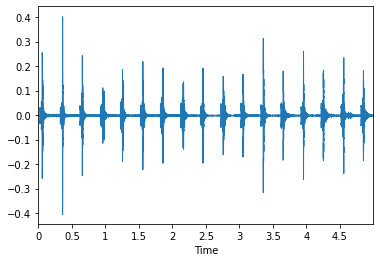

In [13]:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)

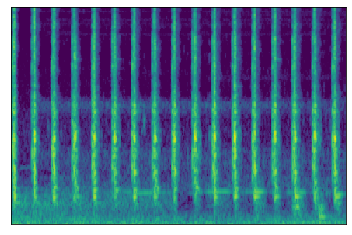

In [14]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')

In [15]:
train_data = ESC50Data('audio', train, 'filename', 'category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1600 [00:00<?, ?it/s]

In [16]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [18]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
device

device(type='cuda', index=0)

In [19]:
model = ESC50Model(input_shape=(1,128,431), batch_size=16, num_cats=50).to(device)

In [20]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [21]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 60
train_losses = []
valid_losses = []

In [22]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [23]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 3.7471306824684145
Epoch - 1 Valid-Loss : 3.148101625442505 Valid-Accuracy : 0.2325
Epoch - 2 Train-Loss : 2.895070877075195
Epoch - 2 Valid-Loss : 2.6397115135192872 Valid-Accuracy : 0.3575
Epoch - 3 Train-Loss : 2.2406820583343507
Epoch - 3 Valid-Loss : 2.3734951782226563 Valid-Accuracy : 0.4
Epoch - 4 Train-Loss : 1.6892533761262893
Epoch - 4 Valid-Loss : 2.1008946561813353 Valid-Accuracy : 0.4675
Epoch - 5 Train-Loss : 1.2185466039180755
Epoch - 5 Valid-Loss : 2.0236616134643555 Valid-Accuracy : 0.4725
Epoch - 6 Train-Loss : 0.8940951544046402
Epoch - 6 Valid-Loss : 1.8793977212905884 Valid-Accuracy : 0.4925
Epoch - 7 Train-Loss : 0.6716529184579849
Epoch - 7 Valid-Loss : 1.8779864358901976 Valid-Accuracy : 0.52
Epoch - 8 Train-Loss : 0.4858337764441967
Epoch - 8 Valid-Loss : 1.7091816806793212 Valid-Accuracy : 0.545
Epoch - 9 Train-Loss : 0.37865298457443713
Epoch - 9 Valid-Loss : 1.8396115112304687 Valid-Accuracy : 0.4975
Epoch - 10 Train-Loss : 0.324949185

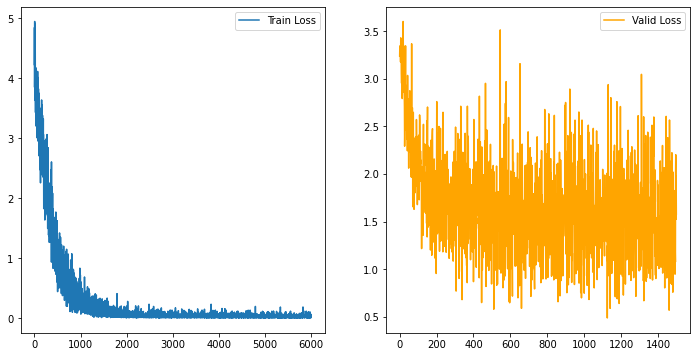

In [24]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [25]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [26]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.407118228673935
Epoch - 1 Valid-Loss : 1.5924193787574767 Valid-Accuracy : 0.565
Epoch - 2 Train-Loss : 1.052034808397293
Epoch - 2 Valid-Loss : 1.56106294631958 Valid-Accuracy : 0.59
Epoch - 3 Train-Loss : 0.6737117202579975
Epoch - 3 Valid-Loss : 1.7129689264297485 Valid-Accuracy : 0.5525
Epoch - 4 Train-Loss : 0.47035630479454993
Epoch - 4 Valid-Loss : 1.1908151578903199 Valid-Accuracy : 0.6475
Epoch - 5 Train-Loss : 0.37209827460348605
Epoch - 5 Valid-Loss : 1.071609729528427 Valid-Accuracy : 0.695
Epoch - 6 Train-Loss : 0.2442051763087511
Epoch - 6 Valid-Loss : 1.106289894580841 Valid-Accuracy : 0.67
Epoch - 7 Train-Loss : 0.20522245332598688
Epoch - 7 Valid-Loss : 1.2727599191665648 Valid-Accuracy : 0.685
Epoch - 8 Train-Loss : 0.11979606528766454
Epoch - 8 Valid-Loss : 0.9689958792924881 Valid-Accuracy : 0.74
Epoch - 9 Train-Loss : 0.12843427110463382
Epoch - 9 Valid-Loss : 1.0075737780332565 Valid-Accuracy : 0.7375
Changed learning rate to 2e-05
Epoch -

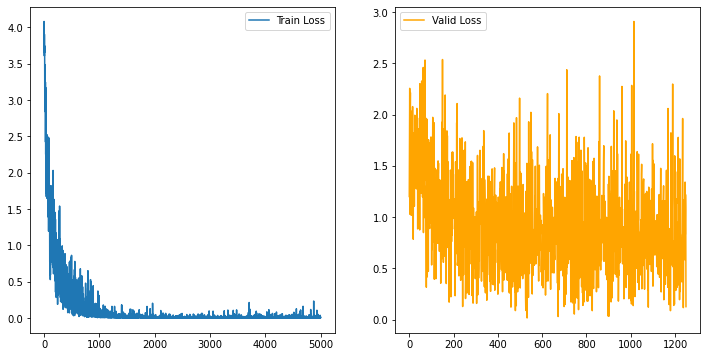

In [28]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [30]:
with open('esc50resnet.pth','wb') as f:
  torch.save(resnet_model, f)

In [31]:
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [ ]:
from google.colab import drive
!mkdir gdrive
drive.mount('gdrive')
!cp esc50resnet.pth gdrive/My\ Drive/
!cp indtocat.pkl gdrive/My\ Drive/

In [32]:
import IPython
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='/content/ESC-50-master/audio/1-116765-A-41.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

chainsaw


In [33]:
import json
json.dump(open('../indcat.json'),indtocat)

{0: 'airplane',
 1: 'breathing',
 2: 'brushing_teeth',
 3: 'can_opening',
 4: 'car_horn',
 5: 'cat',
 6: 'chainsaw',
 7: 'chirping_birds',
 8: 'church_bells',
 9: 'clapping',
 10: 'clock_alarm',
 11: 'clock_tick',
 12: 'coughing',
 13: 'cow',
 14: 'crackling_fire',
 15: 'crickets',
 16: 'crow',
 17: 'crying_baby',
 18: 'dog',
 19: 'door_wood_creaks',
 20: 'door_wood_knock',
 21: 'drinking_sipping',
 22: 'engine',
 23: 'fireworks',
 24: 'footsteps',
 25: 'frog',
 26: 'glass_breaking',
 27: 'hand_saw',
 28: 'helicopter',
 29: 'hen',
 30: 'insects',
 31: 'keyboard_typing',
 32: 'laughing',
 33: 'mouse_click',
 34: 'pig',
 35: 'pouring_water',
 36: 'rain',
 37: 'rooster',
 38: 'sea_waves',
 39: 'sheep',
 40: 'siren',
 41: 'sneezing',
 42: 'snoring',
 43: 'thunderstorm',
 44: 'toilet_flush',
 45: 'train',
 46: 'vacuum_cleaner',
 47: 'washing_machine',
 48: 'water_drops',
 49: 'wind'}

In [ ]:
!wget 'http://soundbible.com/grab.php?id=557&type=wav' -O "baby.wav"
filename='baby.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

--2022-07-28 02:40:53--  http://soundbible.com/grab.php?id=557&type=wav
Resolving soundbible.com (soundbible.com)... 169.47.128.197
Connecting to soundbible.com (soundbible.com)|169.47.128.197|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://soundbible.com/grab.php?id=557&type=wav [following]
--2022-07-28 02:40:54--  https://soundbible.com/grab.php?id=557&type=wav
Connecting to soundbible.com (soundbible.com)|169.47.128.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘baby.wav’

baby.wav                [<=>                 ]       0  --.-KB/s               

In [ ]:
!wget 'http://soundbible.com/grab.php?id=557&type=wav' -O "baby.wav"
filename='baby.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

In [ ]:
!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
filename='cat.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))